# Reproducing previous Machine-learning paper

ddd

In [12]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.metrics

import matplotlib
import matplotlib.pyplot

In [2]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [3]:
from xbt_dataset import XbtDataset

In [54]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [4]:
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/annual_csv',
    'pangeo': '/data/misc/xbt-data/annual_csv/',
}
env_date_ranges = {
    'MO_scitools': (1996,2015),
    'pangeo': (1966,2015)
}

In [5]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year']

In [6]:
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

In [123]:
xbt_labelled = xbt_full_dataset.filter_obs('labelled', 'labelled')

extracting labelled


In [139]:
xbt_labelled.xbt_df = xbt_labelled.xbt_df[xbt_labelled.xbt_df.max_depth < 2000.0]
xbt_labelled.xbt_df = xbt_labelled.xbt_df[xbt_labelled.xbt_df.max_depth > 0.0]

In [55]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)


In [89]:
imeta_model = imeta_classes.apply(lambda t1: t1[0]).astype('category', catergories=xbt_labelled['model'].cat.categories)
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1]).astype('category', catergories=xbt_labelled['manufacturer'].cat.categories)

In [8]:
def classify_subset(classifier_class, xbt_subset, x_features, y_feature):
    (ml_ds, ml_encoders) = xbt_subset.filter_features(x_features).get_ml_dataset()
    (ml_target, target_encoders) = xbt_subset.filter_features([y_feature]).get_ml_dataset()
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(ml_ds, ml_target)
    clf_mlp1 = classifier_class()
    clf_mlp1.fit(X_train, y_train)
    y_res_train = clf_mlp1.predict(X_train)
    metric_train = sklearn.metrics.precision_recall_fscore_support(y_train, y_res_train)
    y_res_test = clf_mlp1.predict(X_test)
    metric_test = sklearn.metrics.precision_recall_fscore_support(y_test, y_res_test)
    return {'classifier':clf_mlp1,'metrics_train': metric_train, 'metrics_test': metric_test}

In [14]:
classify_nnet = functools.partial(classify_subset, sklearn.neural_network.MLPClassifier)

In [15]:
results_model1 = {}
results_manufacturer1 = {}

In [19]:
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]+1):
    xbt_subset = xbt_labelled.filter_obs('year', year)
    print(f'testing classification model {year}')
    try:
        results_model1[year] = classify_nnet(xbt_subset, input_feature_names, 'model')
    except Exception as e1:
        print(f'Error processing model {year} - {e1}')
    print(f'testing classification manufacturer {year}')
    try:
        results_manufacturer1[year] = classify_nnet(xbt_subset, input_feature_names, 'manufacturer')
    except Exception as e1:
        print(f'Error processing manufacturer {year} - {e1}')


testing classification model 1966


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


testing classification manufacturer 1966


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


testing classification model 1967


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

testing classification manufacturer 1967
testing classification model 1968


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


testing classification manufacturer 1968
testing classification model 1969


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


testing classification manufacturer 1969
testing classification model 1970
testing classification manufacturer 1970
testing classification model 1971
testing classification manufacturer 1971
testing classification model 1972


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1972
testing classification model 1973


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1973
testing classification model 1974


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1974
testing classification model 1975


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

testing classification manufacturer 1975
testing classification model 1976
testing classification manufacturer 1976
testing classification model 1977


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1977
testing classification model 1978
testing classification manufacturer 1978
testing classification model 1979


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1979
testing classification model 1980


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1980
testing classification model 1981


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1981
testing classification model 1982


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1982


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing classification model 1983
testing classification manufacturer 1983
testing classification model 1984


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1984


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing classification model 1985


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/met

testing classification manufacturer 1985


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing classification model 1986


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/met

testing classification manufacturer 1986


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 1987


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1987


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing classification model 1988


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification manufacturer 1988


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing classification model 1989


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification manufacturer 1989
testing classification model 1990


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1990


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 1991


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1991


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 1992


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1992


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 1993


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1993
testing classification model 1994


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1994


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 1995
Error processing model 1995 - Input contains NaN, infinity or a value too large for dtype('float64').
testing classification manufacturer 1995
Error processing manufacturer 1995 - Input contains NaN, infinity or a value too large for dtype('float64').
testing classification model 1996


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/met

testing classification manufacturer 1996
testing classification model 1997


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

testing classification manufacturer 1997


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 1998


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification manufacturer 1998


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing classification model 1999


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification manufacturer 1999


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2000


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/met

testing classification manufacturer 2000


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2001


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/met

testing classification manufacturer 2001


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2002


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification manufacturer 2002


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2003


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/met

testing classification manufacturer 2003


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing classification model 2004


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification manufacturer 2004


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2005


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/met

testing classification manufacturer 2005


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification model 2006


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2006


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2007


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification manufacturer 2007


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2008


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2008


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2009


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification manufacturer 2009


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2010


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification manufacturer 2010


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

testing classification model 2011


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

testing classification manufacturer 2011


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2012


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2012


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2013


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2013


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2014


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2014
testing classification model 2015


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2015
testing classification model 2016
Error processing model 2016 - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
testing classification manufacturer 2016
Error processing manufacturer 2016 - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [237]:
year = 1995
xbt_subset = xbt_labelled.filter_obs('year', year)

In [246]:
results_model1[year] = classify_nnet(xbt_subset, input_feature_names, 'model')

/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/skl

In [247]:
results_manufacturer1[year] = classify_nnet(xbt_subset, input_feature_names, 'manufacturer')

/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [207]:
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]+1):
    print(f'processing year {year}')
    xbt_subset = xbt_labelled.filter_obs('year',year)
    xbt_model1, enc_model1 = xbt_subset.filter_features(['model']).get_ml_dataset()
    enc_model1 = enc_model1[0]
    xbt_manufacturer1, enc_manuf1 = xbt_subset.filter_features(['manufacturer']).get_ml_dataset()
    enc_manuf1 = enc_manuf1[0]
    
    imeta_output = xbt_subset.xbt_df.apply(lambda x: imeta_classification(x), axis=1)
    imeta_model1 = enc_model1.transform(pandas.DataFrame({'imeta_model':imeta_output.apply(lambda x: x[0])}))
    imeta_manuf1 = enc_manuf1.transform(pandas.DataFrame({'imeta_manufacturer':imeta_output.apply(lambda x: x[1])}))
    
    if enc_model1.categories_[0].shape[0] == 1:
        (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = (1.0, 1.0, 1.0, xbt_subset.shape[0])
    else:
        (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = sklearn.metrics.precision_recall_fscore_support(xbt_model1, imeta_model1,average='macro')
    if enc_manuf1.categories_[0].shape[0] == 1:
        (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = (1.0, 1.0, 1.0, xbt_subset.shape[0])
    else:
        (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = sklearn.metrics.precision_recall_fscore_support(xbt_manufacturer1, imeta_manuf1,average='macro')

    imeta_results += [{'year': year,
                       'imeta_model_recall': im_rec_model,
                       'imeta_model_precision': im_pr_model,
                       'imeta_manuf_recall': im_rec_manuf,
                       'imeta_manuf_precision': im_pr_manuf,
                       
                      }]

processing year 1966
processing year 1967
processing year 1968
processing year 1969
processing year 1970
processing year 1971
processing year 1972


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1973


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1974


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1975


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1976


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1977


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1978


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1979


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1980


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1981


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1982


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1983


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1984


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1985


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1986


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1987


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1988


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1989


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1990


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1991


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1992


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1993


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1994


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1995


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1996


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1997


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1998


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1999


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2000


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2001


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2002


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2003


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2004


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2005


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2006


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2007


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2008


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2009


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2010


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2011


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2012


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2013


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2014


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2015
processing year 2016


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [210]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [263]:
results_manufacturer1.keys()

dict_keys([1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 1995])

In [270]:
res_manuf_df = pandas.DataFrame({
'year' :list( results_manufacturer1.keys()),
'recall_manuf_train_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_train'][1])
    * numpy.array(results_manufacturer1[year1]['metrics_train'][3])) 
    / sum(results_manufacturer1[year1]['metrics_train'][3])  
    for year1 in results_manufacturer1.keys()],
'precision_manuf_train_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_train'][0])
    * numpy.array(results_manufacturer1[year1]['metrics_train'][3])) 
    / sum(results_manufacturer1[year1]['metrics_train'][3])  
    for year1 in results_manufacturer1.keys()],

'recall_manuf_test_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_test'][1])
    * numpy.array(results_manufacturer1[year1]['metrics_test'][3])) 
    / sum(results_manufacturer1[year1]['metrics_test'][3])  
    for year1 in results_manufacturer1.keys()],
'precision_manuf_test_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_test'][0])
    * numpy.array(results_manufacturer1[year1]['metrics_test'][3])) 
    / sum(results_manufacturer1[year1]['metrics_test'][3])  
    for year1 in results_manufacturer1.keys()],
})
res_manuf_df.sort_values(by='year', inplace=True)

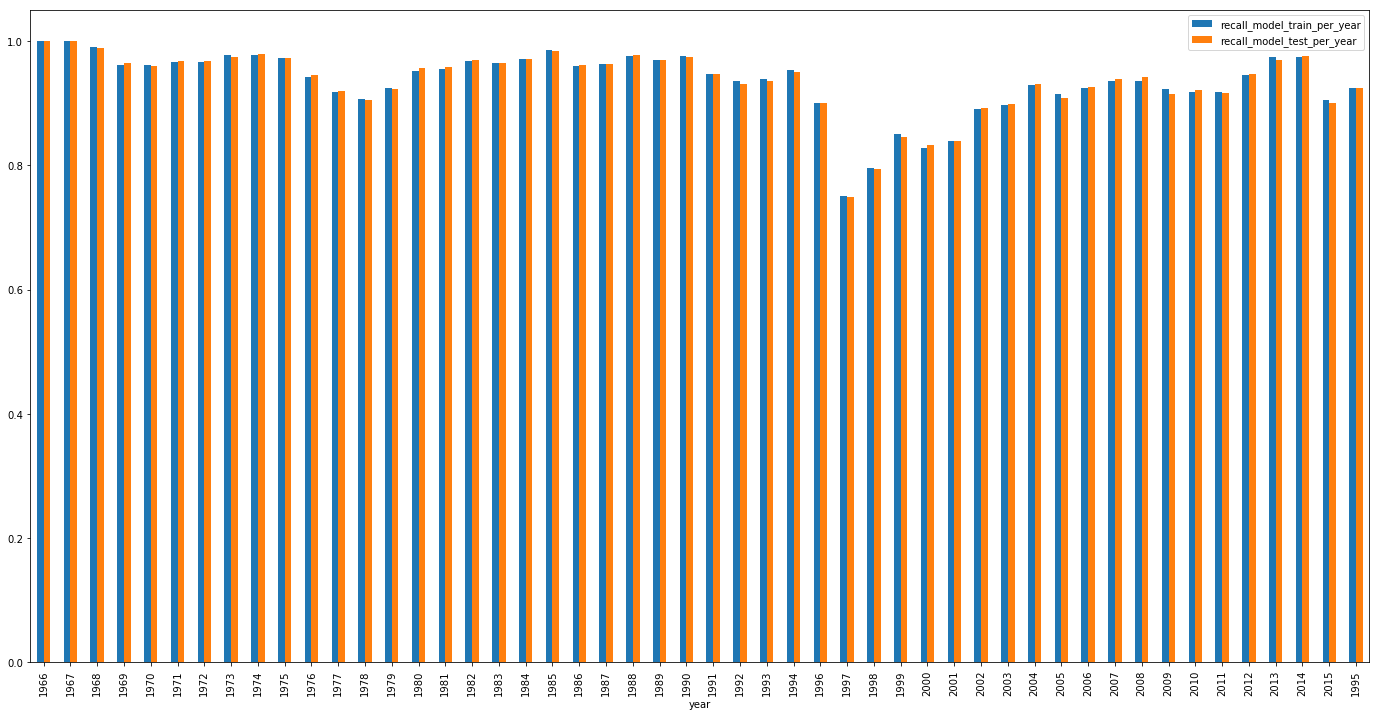

In [271]:
res_model_df.plot.bar(x='year',y=['recall_model_train_per_year','recall_model_test_per_year'], figsize=(24,12))

In [272]:
res_model_df = pandas.DataFrame({
'year' : list(results_model1),
'recall_model_train_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_train'][1])
    * numpy.array(results_model1[year1]['metrics_train'][3])) 
    / sum(results_model1[year1]['metrics_train'][3])  
    for year1 in results_model1.keys()],
'precision_model_train_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_train'][0])
    * numpy.array(results_model1[year1]['metrics_train'][3])) 
    / sum(results_model1[year1]['metrics_train'][3])  
    for year1 in results_model1.keys()],

'recall_model_test_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_test'][1])
    * numpy.array(results_model1[year1]['metrics_test'][3])) 
    / sum(results_model1[year1]['metrics_test'][3])  
    for year1 in results_model1.keys()],
'precision_model_test_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_test'][0])
    * numpy.array(results_model1[year1]['metrics_test'][3])) 
    / sum(results_model1[year1]['metrics_test'][3])  
    for year1 in results_model1.keys()],
})
res_model_df.sort_values(by='year', inplace=True)

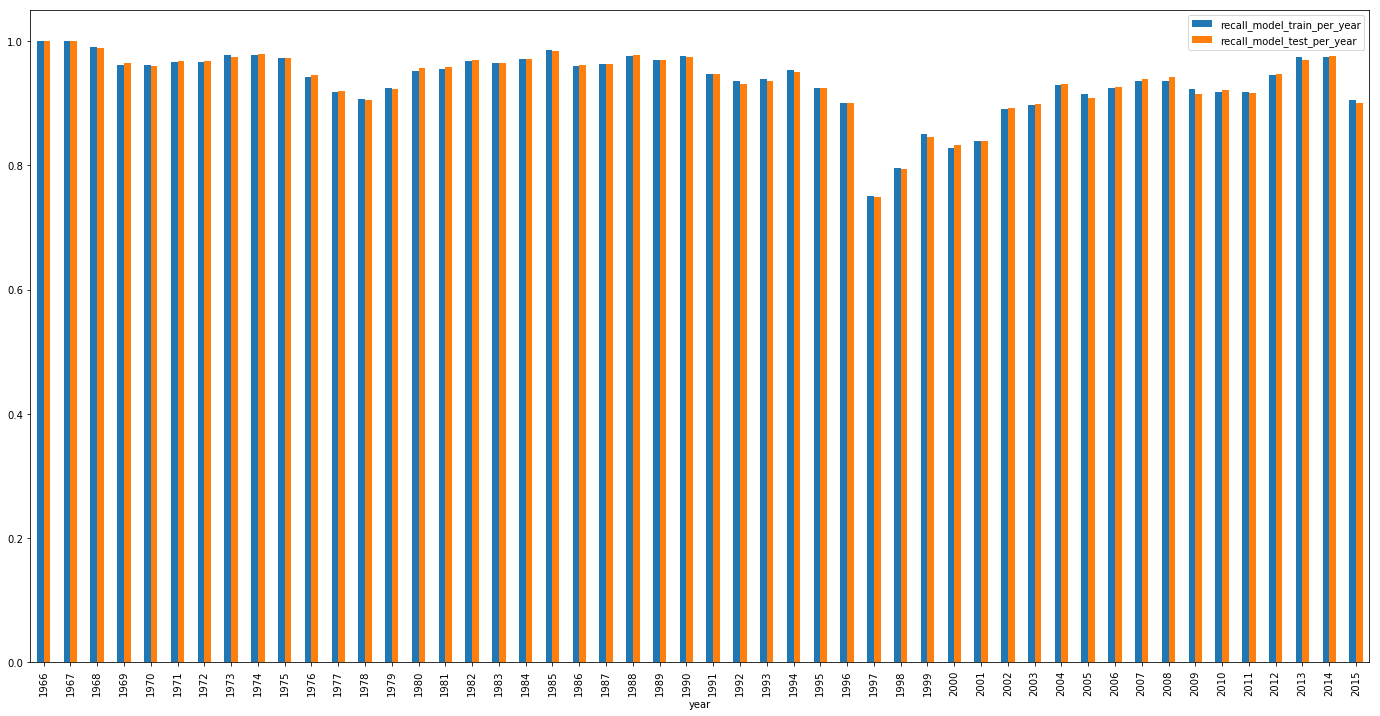

In [273]:
res_model_df.plot.bar(x='year',y=['recall_model_train_per_year','recall_model_test_per_year'], figsize=(24,12))

In [282]:
results_df = pandas.merge(res_model_df, res_manuf_df).merge(imeta_res_df)

In [284]:
results_df.columns

Index(['year', 'recall_model_train_per_year', 'precision_model_train_per_year',
       'recall_model_test_per_year', 'precision_model_test_per_year',
       'recall_manuf_train_per_year', 'precision_manuf_train_per_year',
       'recall_manuf_test_per_year', 'precision_manuf_test_per_year',
       'imeta_model_recall', 'imeta_model_precision', 'imeta_manuf_recall',
       'imeta_manuf_precision'],
      dtype='object')

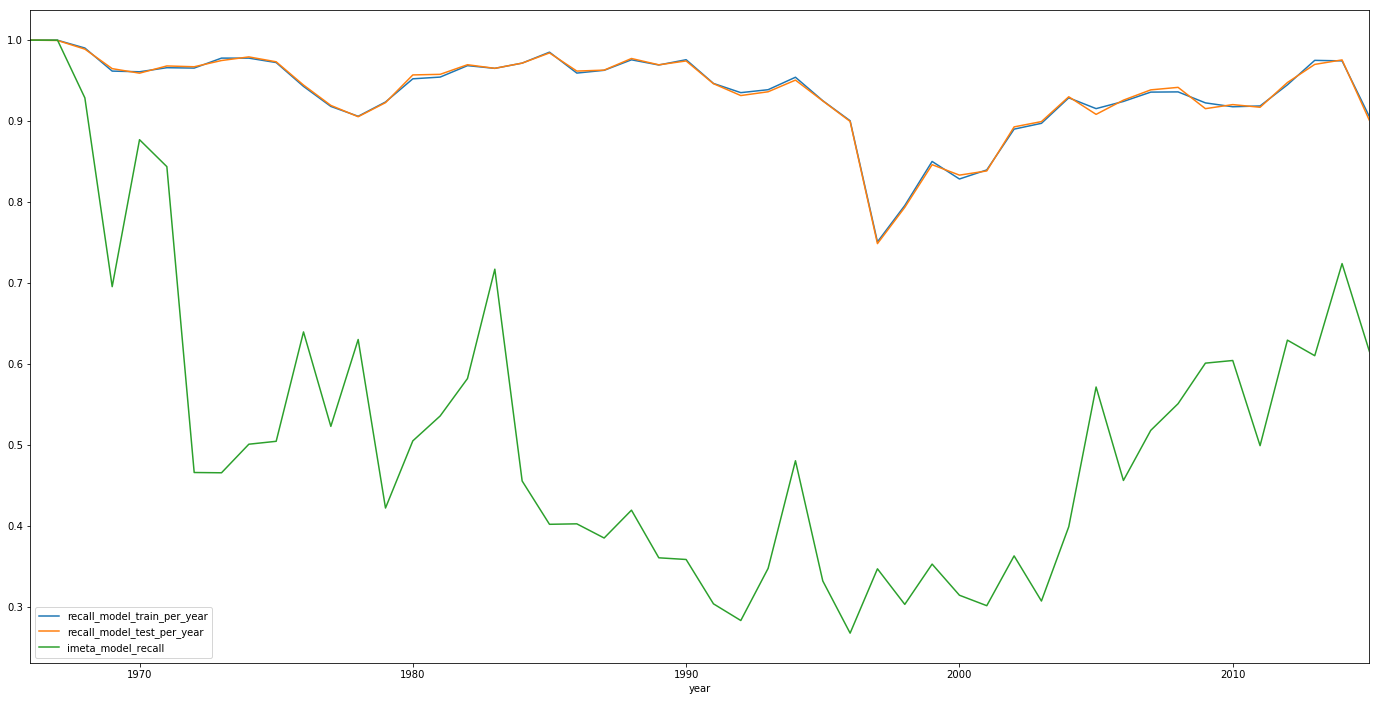

In [286]:
results_df.plot.line(x='year',y=['recall_model_train_per_year','recall_model_test_per_year', 'imeta_model_recall'], figsize=(24,12))

In [ ]:
# print(sklearn.metrics.classification_report(y_train, y_res_train))
